# Kalman filtering

This tutorial is a gentle introduction to Kalman filtering.

Kalman filter (KF) is a powerful algorithm to estimate unknown values of state variables, given (noisy) observations and a physical model describing the evolution of state variables.

In general, the states are the variables we are intersted in and we want to estimate. They can be time-varying (e.g. position, speed of a car, and in general all kinematic variables) or constant parameter (e.g. weight of a car). Note that all estimated parameters will be varying in the KF (the former will vary as the quantity they try to estimate is varying, the latter will vary because we have a more and more accurate approximation of the unknown quantity they try to estimate). To run KF, we need a dynamic model describing how parameters at time $t$ should nominally evolve to the next epoch $t+1$ (here 'nominally' means, in the absence of noise, and under the assumption that the underlying physical model is exact).

On the other hand, observations will be supplied to KF in order to make up for the approximations of the dynamic model. Those observations need not be directly on the state variables. For example, we may want to estimate the 2D position of a vehicle (two state variables $x$ and $y$) and use observations based on a set of ranging beacons. But, at least, we need to provide the observation model, that tells KF how observations would be generated from state variables (simply put: if we had perfect knowledge of the state variables, how would we compute the observation values).

To sum up, KF is efficient in all situations where:

1. We want to estimate unknown states of a system.
2. We have a set of observations, coming from various sensors, providing noisy and partial information on state variables, with a good knowledge of their respective accuracies.
3. We have a prior approximate physical model on how the system should evolve under perfect conditions, and we know to what extent this approximation is correct.

In Tracklib, state and observations are stored as analytical features (AF) in the tracks, and estimation is performed recursively at each timestamp (i.e. for each point in the track). As long as the KF parameters are not intentionnaly modified, the estimation will be performed in the exact same way on different tracks (output estimated values will of course depend on each individual track observations).

Running a KF with $n$ states and $m$ observation variables requires 6 inputs:

1. A dynamic model $F$ (an equation describing how the $n$ state variables are nominally evolving to the next time step).
2. A covariance matrix $Q$ describing how $F$ is a close approximation of the actual behavior of the system. The higher the values of $Q$, the less confidence we have in our model.
3. An observation model $H$ describing how the $n$ state variables are used to compute the $m$ observation variables.
4. A covariance matrix $R$ describing how $H$ is a close approximation of the actual behavior of the sensors. The higher the values of $R$, the less confidence we have in our observations.
5. An intial estimate $X_0$ of the state parameters.
6. A covariance matrix $P_0$ describing the confidence we have in this initial estimate $X_0$.

If we have no information about the initial state (blind initialization of the filter), we can set arbitrary values in $X_0$ and  set $P_0$ to be a diagonal matrix with arbitrarily large variances. 

Note that $Q$ and $R$ values are somehow apportionned to each other. Increasing values of $Q$ (i.e. decreasing our confidence in the dynamic model) is equivalent to decreasing the values of $R$ (hence increasing the confience we have in our observations).

Note also that the physical relation $H$ between state and observations needs not be invertible. This means that we are not assuming that the perfect state of the system can be retrieved solely from the observations at any given epoch. However, if the relation $H$ is only poorly informative, then we would better have a strong and constraining model $F$ to avoid divergence of the solution. On the opposite, a sloppy and non-informative dynamic model should always be paired with invertible or nearly invertible observation model. 

In vanilla KF, the relations $F$ and $H$ must be linear, and are then described by matrices ($n \times n$ matrix for $F$, with $n \times n$ covariance matrix $Q$ and $m \times n$ matrix for $H$ with $m \times m$ covariance matrix $R$). However, Tracklib implements an Unscented Kalman Filter (UKF) which can be used to cover also the cases where $F$ and $H$ are non-linear. In this case they would be described as $\mathbb{R}^n \rightarrow \mathbb{R}^n$ and $\mathbb{R}^n \rightarrow \mathbb{R}^m$ functions for $F$ and $H$, respectively. In this case covariances $Q$ and $R$ still remain in matrix form.

Let's start to implement a KF in Tracklib.


## First we set our environment

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tracklib as trk

In this example, we will generate a synthetic smooth track, add some noise to it, and then try to retrieve the original track. To generate a track we use the function generate from the package Synthetics. The parameter 0.2 describes the smoothness of the track; here we set not to low value, to get smooth and easily predictable kinematics. The parameter dt=10 is the timestamp increment. In order to get reproducible results, we use the seed 123.

In [2]:
trk.seed(123)
track1 = trk.generate(0.2, dt=10)
track2 = track1.noise(1)

Generating track from 05/02/2042 00:44:56 to 05/02/2042 01:44:56


Let's inspect the generated tracks

-------------------------------------
GPS track #0 of user 0:
-------------------------------------
  Nb of pt(s):   360
  Ref sys id   : ENU
  Starting at  : 05/02/2042 00:45:06
  Ending at    : 05/02/2042 01:44:56
  Duration     : 3590.000 s
  Length       : 159.242 m
-------------------------------------
Analytical feature(s):
 - abs_curv
-------------------------------------



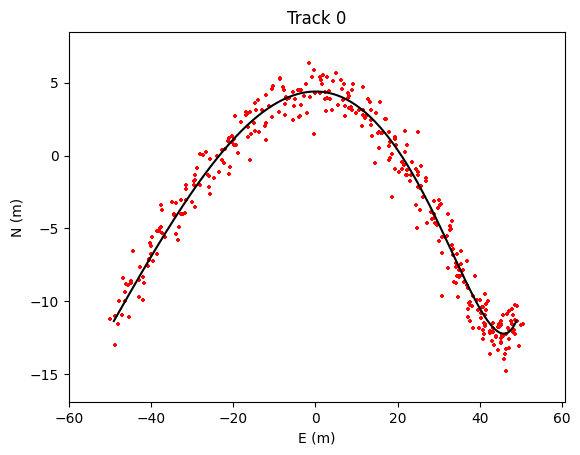

In [3]:
track1.summary()
track1.plot('k-')
track2.plot('r+')
plt.show()

In this problem, we are interested in 4 parameters: 2 position parameters ($x$ and $y$) and 2 speed parameters ($v_x$ and $v_y$). The state vector is then $X = [x, y, v_x, v_y]^T$.

We need now to build the 6 inputs of the model. We are using here standard (linear) Kalman Filter. All ingredients of the filter will be matrices. 

In [4]:
import numpy as np

We will assume the speed of the mobile is constant.

Warning: when we state that the speed of the mobile is constant, it's from a 'statistical' perspective. That does not necessarily mean that the estimated speed of the mobile out of the KF will be rigorously the same during all the sequence, but that the speed between two subsequent epochs is 'approximately' the same. How close they are to each other will be specified by the dynamic model covariance matrix $Q$.

The speed being assumed constant between time steps, we can write: 

$v_x(t+1) = v_x(t)$

$v_y(t+1) = v_y(t)$

Of course, as stated above, those two equations are approximations. The rigorous version would be:

$v_x(t+1) = v_x(t) + \eta_x(t)$

$v_y(t+1) = v_y(t) + \eta_y(t)$


where $\eta_x$ and $\eta_y$ describe a noise contribution on the model. For example, for a car trying to drive at constant speed , these parameters can represent the wind force variations on the front of the car. The wind being impredictable (they can as well push or slow down the car) there is no choice but considering its contribution in the covariance matrix $Q$. So we will use the two simplified equations.

On the other hand, the evolution of the positions $x$ and $y$ is well described by kinematics equations:<br />
$x(t+1) = x(t) + v_x(t)$<br />
$y(t+1) = y(t) + v_y(t)$<br />

These equations (corresponding to a first order Taylor expansion) are perfectly valid as long as we assume that the acceleration is null (which is the case, since we assumed no speed variations on any component $x$ and $y$).

Putting all these equations together gives:

$x(t+1) = x(t) + v_x(t)$

$y(t+1) = y(t) + v_y(t)$

$v_x(t+1) = v_x(t)$

$v_y(t+1) = v_y(t)$

which is expressed in matrix form as:


$$
\begin{bmatrix}
x\\
y\\
v_x\\
v_y
\end{bmatrix}_{t+1} = \begin{bmatrix}
1 & 0 & 1 & 0\\
0 & 1 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}\begin{bmatrix}
x\\
y\\
v_x\\
v_y
\end{bmatrix}_{t} 
$$


This is the matrix we are going to feed to the KF:

In [5]:
F = np.array([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]])

Note that this matrix can be directly and equivalently formed from Dynamics library:

In [6]:
F = trk.DYN_MAT_2D_CST_SPEED(1)

The covariance matrix might be a bit tricky to parameterize, but we'll start like that: 

In [7]:
Q = np.array([
    [1e-8, 0, 0, 0],
    [0, 1e-8, 0, 0],
    [0, 0, 2e-4, 0],
    [0, 0, 0, 2e-4]])

It can be easily interpreted: the bottom-right value 2e-4, means that the last dynamic equation $v_y(t+1) = v_y(t)$ is true, up to a random variable $\eta_y$, whose variance is 2e-4 (i.e. with 0.01414 standard deviation). This means that, between two subsequent epochs in the track, the speed on each component $v_x$ and $v_y$ would typically not increase or decrease by more than 0.05 m/s ($3\sigma$). Similarly, the value 1e-8 on the first top rows, means that the update equations on positions $x(t+1) = x(t) + v_x(t)$ and $y(t+1) = y(t) + v_y(t)$ are accurate up to a random noise of standard deviation 0.0001 m.

For the observation model, we will assume that the GPS provides (noisy) estimates of the position variables $x$ and $y$. The model $H$ is therefore a $2 \times 4$ matrix (it takes as input the 4 state parameters, and computes 2 observation values). Since the observation are directly the first two state parameters, the relation is simply:

$$
\begin{bmatrix}
x_{GPS}\\
y_{GPS}
\end{bmatrix}_{t+1} = \begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}\begin{bmatrix}
x\\
y\\
v_x\\
v_y
\end{bmatrix}_{t} 
$$

and then $H$ is:

In [8]:
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]])

The first (resp. second) row describes the computation of observation on $x$ (resp $y$) from the GPS. Note that these observations are only noisy measurements on the actual unknown state parameters $x$ and $y$. The noise variance is given by the matrix $R$. We will assume that the GPS has an accuracy of about 1 m on each axis. There is no correlation between errors on each individual component so the matrix is diagonal: 

In [9]:
R = np.array([
    [1, 0],
    [0, 1]])

Eventually, we will set the initial state $X_0$ from the first two (noisy) observations of the GPS, stored in the positions of the track, and we will start with zero speed.

In [10]:
X0 = np.array([
    [track2[0].position.getX()],
    [track2[0].position.getY()],
    [0],
    [0]])

We provide the associated variance on these initial estimates:

In [11]:
P0 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1e4, 0],
    [0, 0, 0, 1e4]])

Unsurprisingly, the variances set on the initial position $x$ and $y$ are the same as the GPS variance (since $X_0$ has been initialized from the GPS measurements, this seems to be a reasonable assumption). If we had a perfect information on the starting point we could set a much lower variance, for example 1e-4 if we had centimetric accuracy on the starting point. However, this is at risk of slow convergence if the starting point happens to be erroneous. In order to avoid too slow convergence of the filter, it is often better to be conservative on our knowledge of initialization, and set $P_0$ with high variances. That is the case for the speed. We don't know the initial speed of the mobile (no speed sensor) but assuming we are dealing with a terrestrial vehicle, an initial variance of speed of 1e4 (100 m/s standard deviation) on each axis, seems more than reasonable. 

Then, we can initialize a Kalman object with those 6 matrices:

In [12]:
UKF = trk.KalmanFilter()
UKF.setTransition(F, Q)
UKF.setObservation(H, R)
UKF.setInitState(X0, P0)

The second line creates the Kalman filter object. The third line is for the dynamics (a.k.a. transition) model. The fourth line inputs the observation model. Eventually, the initial state is specified in the fifth line. To check that our parameterization is correct, a convenient tool is provided with the summary function:

In [13]:
UKF.summary()

Kalman filter
Type: standard (KF)
Stationnarity: Yes
Number of states         n = 4
Number of observations   m = 2
Dynamic model [n x n]:
[[1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]
 [0 0 0 1]]
E.g. x = [[3 1 3 4]] => F(x) = [[6 5 3 4]]
-----------------------------------------------------------
Dynamic model covariance matrix [n x n]:
[[1.e-08 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-08 0.e+00 0.e+00]
 [0.e+00 0.e+00 2.e-04 0.e+00]
 [0.e+00 0.e+00 0.e+00 2.e-04]]
Observation model [m x n]:
[[1 0 0 0]
 [0 1 0 0]]
E.g. x = [[3 1 3 4]] => H(x) = [[3 1]]
-----------------------------------------------------------
Observation model covariance matrix [m x m]:
[[1 0]
 [0 1]]
Initial state vector [n x 1]
[[-48.88511049]
 [-12.97500723]
 [  0.        ]
 [  0.        ]]
-----------------------------------------------------------
Initial state covariance matrix [n x n]
[[1.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+04 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+04]]


It sums up all the parameters of the KF and also provides typical examples of transitions and measurements to check that everything is correct. For example, the line 

E.g. x = [[3 1 3 4]] => F(x) = [[6 5 3 4]]  

is provided to check that, under the model assumptions, if the state at time $t$ is $[3~1~3~4]^T$ then at next epoch $t+1$, it would be $[6~5~3~4]^T$. This is correct since indeed:

$3 + 3 \rightarrow 6~~$   ($x$ update)

$1 + 4 \rightarrow 5~~$   ($y$ update)

$3 \rightarrow 3~~$   ($v_x$ update, no speed change)

$4 \rightarrow 4~~$   ($v_y$ update, no speed change)

Similarly, for the observation model, the same fictive state [[3 1 3 4]] would indeed give the observation (GPS) vector [[3 1]].

Finally, we can perform the estimation on the track2 (noisy version of ground truth). We specify that the $m=2$ observations required by UKF object can be retrieved in "x" and "y" (i.e. track positions) AFs of track2.

In [14]:
UKF.estimate(track2, ["x", "y"])

100% (360 of 360) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Let's inspect the fields created in track2:

In [15]:
track2.summary()

-------------------------------------
GPS track #0 of user 0:
-------------------------------------
  Nb of pt(s):   360
  Ref sys id   : ENU
  Starting at  : 05/02/2042 00:45:06
  Ending at    : 05/02/2042 01:44:56
  Duration     : 3590.000 s
  Length       : 801.411 m
-------------------------------------
Analytical feature(s):
 - abs_curv
 - kf_0
 - kf_1
 - kf_2
 - kf_3
 - kf_0_std
 - kf_1_std
 - kf_2_std
 - kf_3_std
 - kf_x_inov
 - kf_x_inov_std
 - kf_y_inov
 - kf_y_inov_std
 - kf_gain
 - kf_P
-------------------------------------



All the fields created by the Kalman filter start with "kf_". The first four variables kf_0 to kf_3 are the estimated values (at each time step) of the four state parameters $x$, $y$, $v_x$ and $v_y$. The next four AFs kf_0_std to kf_3_std are their associated standard deviations. The complete $4 \times 4$ covariance matrix can be retrieved in kf_P. All the other parameters are used for trouble-shooting of the KF. 

To check out the results, we plot the original ground truth track (in black), the noisy observations from track2 (in red dots) and the filtered track (blue), where "kf_0" and "kf_1" are the two AFs containing the estimated states $x$ and $y$.

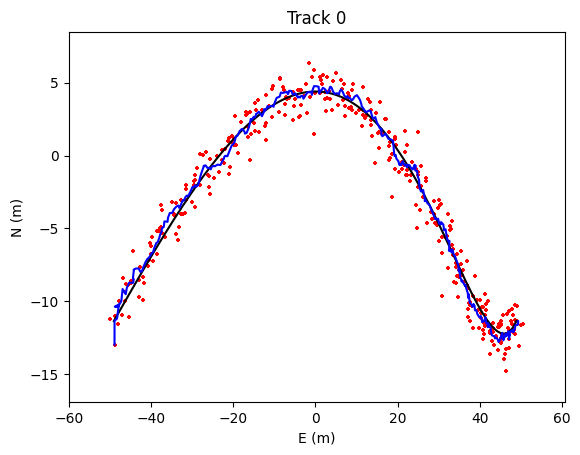

In [16]:
track1.plot('k-')
plt.plot(track2['kf_0'], track2['kf_1'], 'b-')
track2.plot('r+')

plt.show()


We can also plot the estimated speeds $v_x$ and $v_y$.

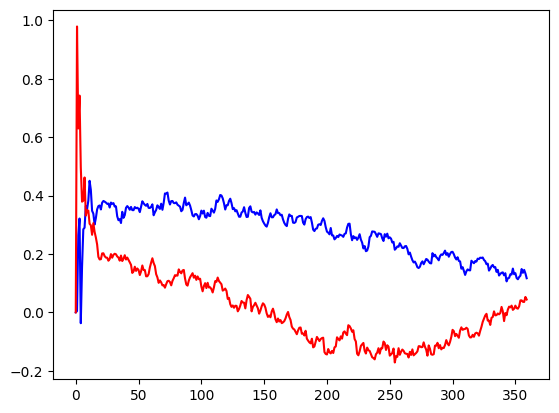

In [17]:
plt.plot(track2['kf_2'], 'b-')
plt.plot(track2['kf_3'], 'r-')

plt.show()

It is interesting to repeat the experimentation with completely wrong initial estimate of position $x$. We then observe that the filter takes a bit longer to converge. The issue is instantly solve if we are more conservative on $P_0$ and set its top-left value to, for example, 1e6 (1000 m standard deviation)

100% (360 of 360) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


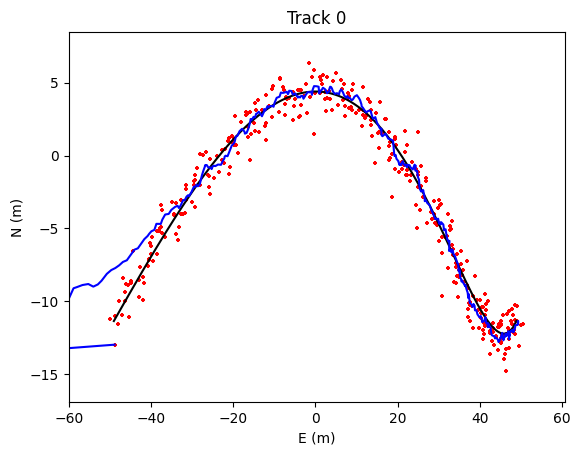

In [18]:
X0 = np.array([
    [100],
    [0],
    [0],
    [0]])

P0 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1e4, 0],
    [0, 0, 0, 1e4]])

UKF.setInitState(X0, P0)

UKF.estimate(track2, ["x", "y"])

track1.plot('k-')
plt.plot(track2['kf_0'], track2['kf_1'], 'b-')
track2.plot('r+')

plt.show()

Let's see the evolution of the standard deviations of $x$ position (blue) and speed (red) estimates. It converges quite fast, even with the inaccurate initialization.

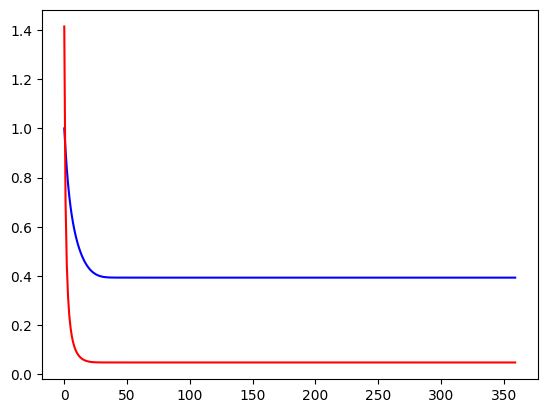

In [19]:
plt.plot(track2['kf_0_std'], 'b-')
plt.plot(track2['kf_2_std'], 'r-')

plt.show()

We can also plot the innovations: difference between the expected observation (based on the current estimation of parameters) and the actual observations. A large innovation occurs at the begining of the filter in case of wrong initialization. Here we see that the innovation is especially large on the $x$ observation, because $x$ is not initialized properly.

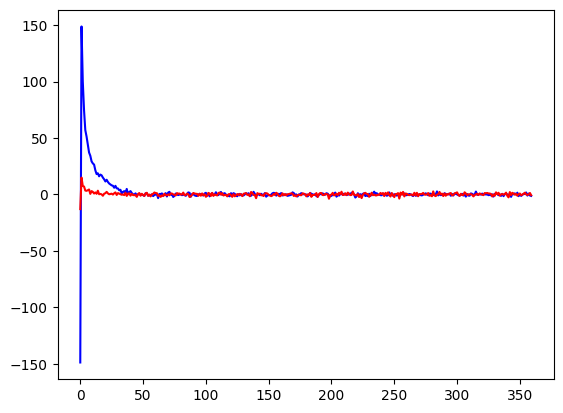

In [20]:
plt.plot(track2['kf_x_inov'], 'b-')
plt.plot(track2['kf_y_inov'], 'r-')

plt.show()

Once the filter has converged, the innovation should be a white noise process of standard deviations given by the observation covariance matrix $R$. Here we retrieve the 1 m white noise of the GPS sensor on both axes $x$ and $y$. 

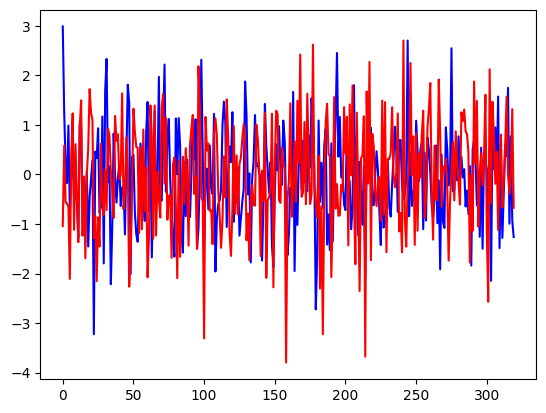

In [21]:
plt.plot(track2['kf_x_inov'][40:], 'b-')
plt.plot(track2['kf_y_inov'][40:], 'r-')

plt.show()

It is interesting as well to repeat the experiment, but with wrong initialization on speed $v_x$ and too optimistic variance on speed initialization in $P_0$ (1 m/s standard deviation). 

100% (360 of 360) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


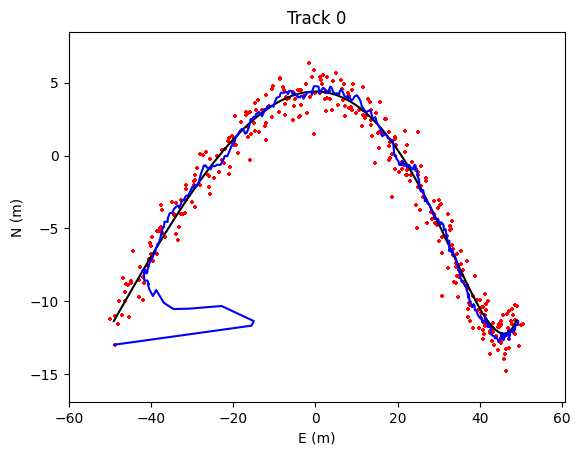

In [22]:
X0 = np.array([
    [0],
    [0],
    [100],
    [0]])

P0 = np.array([
    [1e6, 0, 0, 0],
    [0, 1e6, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]])

UKF.setInitState(X0, P0)

UKF.estimate(track2, ["x", "y"])

track1.plot('k-')
plt.plot(track2['kf_0'], track2['kf_1'], 'b-')
track2.plot('r+')

plt.show()

Here also, the filter takes longer than expected to converge to steady-state.

Let's try another experiment: we will initialize the filter properly (unknown state arbitrarily set at zero values and large variance in covariance matrix) and simulate a fake corrupted data observations at epoch 200. This will in turn corrupt the KF estimation.

100% (360 of 360) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


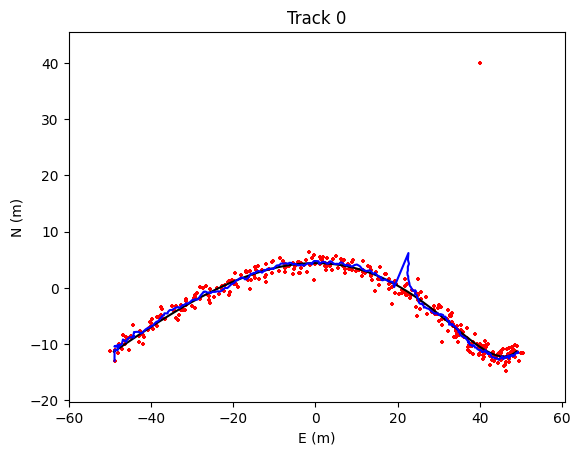

In [23]:
X0 = np.array([
    [0],
    [0],
    [0],
    [0]])

P0 = np.array([
    [1e6, 0, 0, 0],
    [0, 1e6, 0, 0],
    [0, 0, 1e6, 0],
    [0, 0, 0, 1e6]])

track2[200].position.setX(40)
track2[200].position.setY(40)

UKF.setInitState(X0, P0)

UKF.estimate(track2, ["x", "y"])

track1.plot('k-')
plt.plot(track2['kf_0'], track2['kf_1'], 'b-')
track2.plot('r+')

plt.show()

However, fortunately, monitoring innovation AFs ("kf_x_inov" and "kf_y_inov" for the 2 available observations) helps to detect the problem. If the innovation on any given observation is too large (comparatively to its standard deviation), it suggests that observation is not reliable, and may be rejected.  

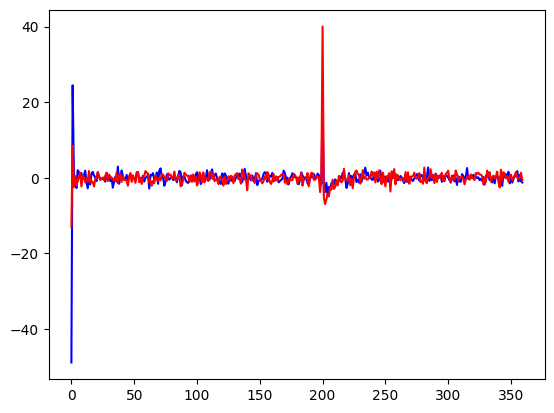

In [24]:
plt.plot(track2['kf_x_inov'], 'b-')
plt.plot(track2['kf_y_inov'], 'r-')

plt.show()